In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

# Load dataset
# Assuming your CSV has columns: 'Question', 'Answer', 'Strength'
data = pd.read_excel('Audio_Team_FinalCleaned.xlsx')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a text
def get_bert_embeddings(text, max_length=512):
    # Tokenize text
    tokens = tokenizer(text,
                       padding='max_length',
                       truncation=True,
                       max_length=max_length,
                       return_tensors='pt')

    # Get BERT output embeddings
    with torch.no_grad():
        outputs = model(**tokens)
      # Extract [CLS] token embedding (representing the entire sequence)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        return cls_embedding

# Create a new list to hold the features, questions, answers, and strengths
features = []

# Extract embeddings for each row in the dataset
for index, row in data.iterrows():
    question = row['Question']
    answer = row['Answer']

    # Get embeddings for both question and answer
    question_embedding = get_bert_embeddings(question)
    answer_embedding = get_bert_embeddings(answer)

    # Concatenate the question and answer embeddings into one feature vector
    combined_embedding = torch.cat((torch.tensor(question_embedding), torch.tensor(answer_embedding)))

    # Append the question, answer, strength, and embedding as a dictionary
    features.append({
        'strength': row['Strength'],
        'embedding': combined_embedding.numpy()  # BERT embedding as a feature
    })

# Convert the list of dictionaries into a DataFrame
features_df = pd.DataFrame(features)

# Convert the 'embedding' column (which contains arrays) into a format that can be saved in a CSV
# This is done by converting the array into a string representation
features_df['embedding'] = features_df['embedding'].apply(lambda x: ','.join(map(str, x)))

# Save the DataFrame with question, answer, strength, and embeddings to a new CSV
features_df.to_csv('bert_features_add_data_cleaned.csv', index=False)

print("BERT feature extraction completed and saved to bert_features.csv!")


BERT feature extraction completed and saved to bert_features.csv!


In [ ]:
pip install --upgrade imbalanced-learn


   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ------ -------------------------------- 41.0/258.3 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.11.0
    Uninstalling imbalanced-learn-0.11.0:
      Successfully uninstalled imbalanced-learn-0.11.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# # Hyperparameter tuning - using GridSearchCV
# The main goal is to improve the model’s performance on unseen data.
# The right hyperparameters can significantly enhance a model's accuracy, reduce overfitting, and lead to a better generalization.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert embeddings and labels
features['embedding'] = features['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=', '))  # Convert string to list
X = np.array(features['embedding'].tolist())
y = features['strength'].values

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit Grid Search
grid_search.fit(X_train.tolist(), y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Step 4: Train the final model using the best parameters
final_model = best_rf.fit(X_train.tolist(), y_train)

# Step 5: Evaluate the final model
y_pred = final_model.predict(X_test.tolist())

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

          -1       0.76      0.79      0.78        33
           0       0.44      0.34      0.39        32
           1       0.53      0.62      0.57        37

    accuracy                           0.59       102
   macro avg       0.58      0.58      0.58       102
weighted avg       0.58      0.59      0.58       102

Confusion Matrix:
 [[26  3  4]
 [ 5 11 16]
 [ 3 11 23]]


In [3]:
# Comparing Accuracy for all of the models
!pip install catboost xgboost scikit-learn

----------------------------------------USING SMOTE--------------------------------------

In [ ]:
# ----------Hyperparameter tuning-----------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Step 1: Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert embeddings and labels
features['embedding'] = features['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=', '))  # Convert string to list
X = np.array(features['embedding'].tolist())
y = features['strength'].values

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and parameter grids for GridSearchCV
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'SVM': (SVC(probability=True, random_state=42), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'NaiveBayes': (GaussianNB(), {}),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    'CatBoost': (CatBoostClassifier(verbose=0, random_state=42), {
        'iterations': [50, 100, 150],
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    })
}

# Dictionary to store results
best_params = {}
results = {}

# Step 3: Hyperparameter Tuning using Grid Search for each model
for model_name, (model, param_grid) in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train.tolist(), y_train)

    # Get the best parameters and estimator
    best_params[model_name] = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Train and evaluate the best model
    best_model.fit(X_train.tolist(), y_train)
    y_pred = best_model.predict(X_test.tolist())

    # Store the results
    results[model_name] = {
        'Best Hyperparameters': best_params[model_name],
        'Classification Report': classification_report(y_test, y_pred, output_dict=True),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Display the results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print("Best Hyperparameters:", result['Best Hyperparameters'])
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", result['Confusion Matrix'])


Tuning hyperparameters for RandomForest...
Tuning hyperparameters for SVM...


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Tuning hyperparameters for DecisionTree...
Tuning hyperparameters for NaiveBayes...
Tuning hyperparameters for AdaBoost...


D:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

Tuning hyperparameters for XGBoost...


ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from collections import Counter

# Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

# Apply the conversion to the 'embedding' column
features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2} for compatibility with SMOTE
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array for model training
y = features['mapped_strength'].values        # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Original training class distribution:", Counter(y_train))
print("Resampled training class distribution:", Counter(y_resampled))

# List of classifiers with optimized hyperparameters for Random Forest
classifiers = {
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(silent=True),
    'Naive Bayes': GaussianNB()
}

# Dictionary to store the results
results = []

# Iterate over classifiers and store performance metrics
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)  # Train on resampled (balanced) data
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the results
    results.append([name, accuracy, precision, recall, f1])

# Create a table to show results
headers = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# If needed: Map predictions back to original labels
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_test_original = np.vectorize(inverse_mapping.get)(y_test)
y_pred_original = np.vectorize(inverse_mapping.get)(y_pred)

# Print classification report for original labels
print(classification_report(y_test_original, y_pred_original))


Original training class distribution: Counter({2: 164, 1: 132, 0: 110})
Resampled training class distribution: Counter({2: 164, 1: 164, 0: 164})


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------+------------+-------------+----------+------------+
| Classifier    |   Accuracy |   Precision |   Recall |   F1-Score |
+===============+============+=============+==========+============+
| Random Forest |   0.558824 |    0.55123  | 0.558824 |   0.551133 |
+---------------+------------+-------------+----------+------------+
| SVM           |   0.637255 |    0.637255 | 0.637255 |   0.63687  |
+---------------+------------+-------------+----------+------------+
| Decision Tree |   0.460784 |    0.456089 | 0.460784 |   0.454484 |
+---------------+------------+-------------+----------+------------+
| AdaBoost      |   0.5      |    0.506696 | 0.5      |   0.502732 |
+---------------+------------+-------------+----------+------------+
| XGBoost       |   0.54902  |    0.54073  | 0.54902  |   0.543511 |
+---------------+------------+-------------+----------+------------+
| CatBoost      |   0.656863 |    0.65381  | 0.656863 |   0.646966 |
+---------------+------------+----

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from collections import Counter
import joblib  # Importing joblib for saving the model

# Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

# Apply the conversion to the 'embedding' column
features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2} for compatibility with SMOTE
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array for model training
y = features['mapped_strength'].values        # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Original training class distribution:", Counter(y_train))
print("Resampled training class distribution:", Counter(y_resampled))

# List of classifiers with optimized hyperparameters for Random Forest
classifiers = {
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(silent=True),
    'Naive Bayes': GaussianNB()
}

# Dictionary to store the results
results = []
best_model = None  # Variable to store the best performing model
best_accuracy = 0  # Variable to store the best accuracy

# Iterate over classifiers and store performance metrics
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)  # Train on resampled (balanced) data
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the results
    results.append([name, accuracy, precision, recall, f1])

    # Update the best model if the current one has better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf

# Create a table to show results
headers = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# If needed: Map predictions back to original labels
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_test_original = np.vectorize(inverse_mapping.get)(y_test)
y_pred_original = np.vectorize(inverse_mapping.get)(y_pred)

# Print classification report for original labels
print(classification_report(y_test_original, y_pred_original))

# Save the best model to a .pkl file
if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')
    print(f"Best model saved as 'best_model.joblib' with accuracy {best_accuracy * 100:.2f}%")


Original training class distribution: Counter({2: 164, 1: 132, 0: 110})
Resampled training class distribution: Counter({2: 164, 1: 164, 0: 164})


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------+------------+-------------+----------+------------+
| Classifier    |   Accuracy |   Precision |   Recall |   F1-Score |
+===============+============+=============+==========+============+
| Random Forest |   0.558824 |    0.55123  | 0.558824 |   0.551133 |
+---------------+------------+-------------+----------+------------+
| SVM           |   0.637255 |    0.637255 | 0.637255 |   0.63687  |
+---------------+------------+-------------+----------+------------+
| Decision Tree |   0.490196 |    0.484539 | 0.490196 |   0.483249 |
+---------------+------------+-------------+----------+------------+
| AdaBoost      |   0.5      |    0.506696 | 0.5      |   0.502732 |
+---------------+------------+-------------+----------+------------+
| XGBoost       |   0.54902  |    0.54073  | 0.54902  |   0.543511 |
+---------------+------------+-------------+----------+------------+
| CatBoost      |   0.656863 |    0.65381  | 0.656863 |   0.646966 |
+---------------+------------+----

In [ ]:
# Linear regression
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load the data
data = pd.read_csv('bert_features_add_data_cleaned.csv')  # Replace with your file path

# Step 2: Ensure all features are numeric and verify the columns
X = data.drop('strength', axis=1, errors='ignore').select_dtypes(include=[float, int])  # Only select numeric columns
y = data['strength']  # Target column

# Print columns and check if X is empty
print("Columns in X:", X.columns)
print("Number of rows in X:", len(X))
if X.empty:
    raise ValueError("The feature set X is empty. Please check that the data contains numeric columns.")

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)

# Step 6: Calculate evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Columns in X: Index([], dtype='object')
Number of rows in X: 508


ValueError: The feature set X is empty. Please check that the data contains numeric columns.

In [ ]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer

# Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

# Apply the conversion to the 'embedding' column
features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2}
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Prepare features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array
y = features['mapped_strength'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model with the best hyperparameters
clf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# LIME: Initialize a LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f'feature_{i}' for i in range(X_train.shape[1])],
    class_names=['Low Strength', 'Medium Strength', 'High Strength'],
    mode='classification'
)

# Choose an instance to explain (e.g., first instance in the test set)
instance_index = 0
instance = X_test[instance_index]

# Generate explanation for the selected instance
exp = explainer.explain_instance(data_row=instance, predict_fn=clf.predict_proba)

# Print the explanation
print(f"Explanation for instance {instance_index} (actual class: {y_test[instance_index]})")
exp.show_in_notebook()  # Display in a Jupyter Notebook
exp.save_to_file('lime_explanation.html')  # Save explanation as an HTML file for external viewing


Explanation for instance 0 (actual class: 1)


D:\Anaconda\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# ------------SHAP----------------
!pip install shap


   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ------ --------------------------------- 71.7/456.1 kB 1.9 MB/s eta 0:00:01
   ---------------------- ----------------- 256.0/456.1 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 4.1 MB/s eta 0:00:00


D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_split", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


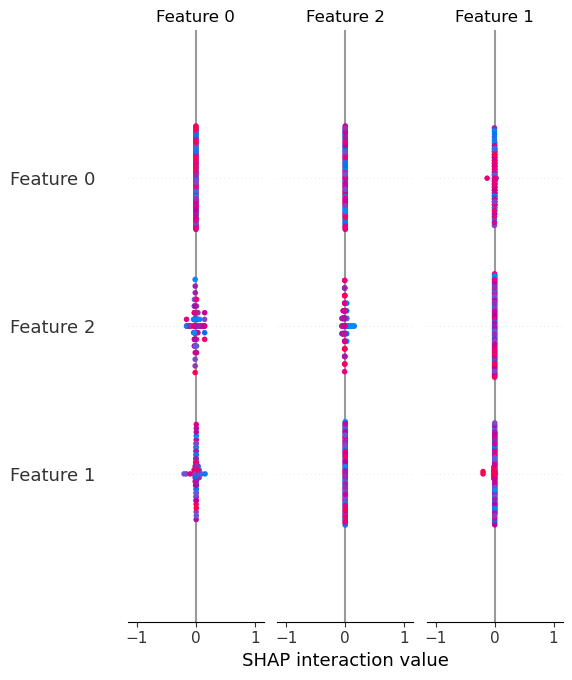

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load the BERT features
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

# Apply the conversion to the 'embedding' column
features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2}
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Ensure embeddings are in numpy array format
y = features['mapped_strength'].values  # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (ensure you are using the best hyperparameters found from GridSearchCV)
model = XGBClassifier(max_depth=10, min_samples_split=2, n_estimators=50, eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.Explainer(model)  # For XGBoost, consider using shap.TreeExplainer(model)
shap_values = explainer(X_test)  # This will compute SHAP values

# Plotting
shap.summary_plot(shap_values, X_test)  # This should work assuming shapes are correct


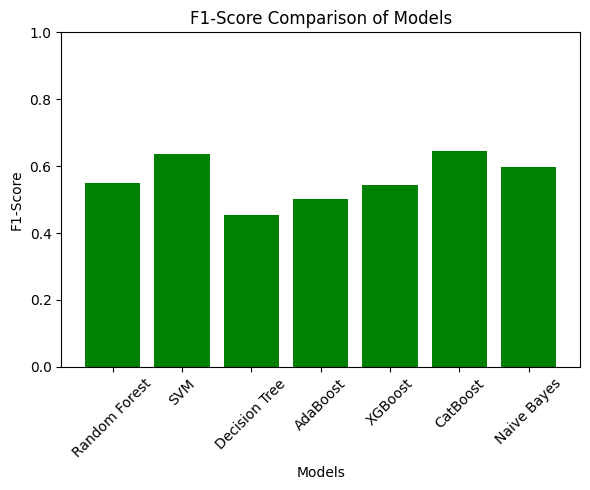

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for F1-scores
models = ['Random Forest', 'SVM', 'Decision Tree', 'AdaBoost', 'XGBoost', 'CatBoost', 'Naive Bayes']
f1_scores = [0.551, 0.636, 0.454, 0.502, 0.543, 0.646, 0.597]

# Create a bar plot
plt.figure(figsize=(6, 5))
plt.bar(models, f1_scores, color='Green')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison of Models')
plt.xticks(rotation=45)  # Rotate model labels for better readability
plt.ylim(0, 1)  # Set the y-axis limit for clarity
plt.tight_layout()
plt.show()


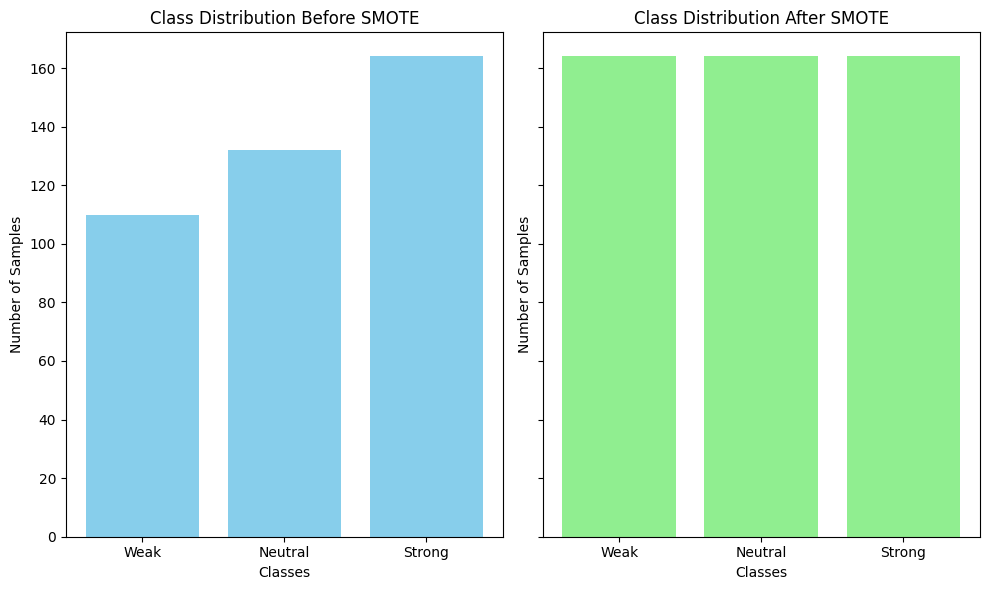

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the original and resampled class distributions
original_counts = Counter(y_train)
resampled_counts = Counter(y_resampled)

# Prepare data for plotting
classes = list(label_mapping.values())  # [0, 1, 2]
class_labels = ['Weak', 'Neutral', 'Strong']  # Add meaningful labels for classes

original_values = [original_counts.get(cls, 0) for cls in classes]
resampled_values = [resampled_counts.get(cls, 0) for cls in classes]

# Plot the class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Before SMOTE
axes[0].bar(class_labels, original_values, color='skyblue')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')

# After SMOTE
axes[1].bar(class_labels, resampled_values, color='lightgreen')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')

# Improve layout
plt.tight_layout()
plt.show()


In [ ]:
pip install -U numpy


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install numpy<2


The system cannot find the file specified.


In [ ]:
pip cache purge


Files removed: 1346
Note: you may need to restart the kernel to use updated packages.


In [4]:

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Load dataset
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2} for compatibility with SMOTE
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array for model training
y = features['mapped_strength'].values        # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Original training class distribution:", Counter(y_train))
print("Resampled training class distribution:", Counter(y_resampled))

# Define base models
random_forest = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)  # probability=True for stacking
naive_bayes = GaussianNB()

# Hyperparameter tuning for base models
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}
# Grid search for Random Forest
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_resampled, y_resampled)
best_rf = grid_rf.best_estimator_

# Grid search for SVM
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_resampled, y_resampled)
best_svm = grid_svm.best_estimator_

# Base models after tuning
base_models = [
    ('Random Forest', best_rf),
    ('SVM', best_svm),
    ('Naive Bayes', naive_bayes),
]

# Define meta-learner (CatBoost)
meta_learner = CatBoostClassifier(verbose=0, random_state=42)

# Hyperparameter tuning for CatBoost (meta-learner)
param_grid_cb = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}
grid_cb = GridSearchCV(meta_learner, param_grid_cb, cv=3, scoring='accuracy', n_jobs=-1)
grid_cb.fit(X_resampled, y_resampled)
best_cb = grid_cb.best_estimator_

# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_cb,
    cv=3,
    n_jobs=-1
)

# Train the stacking model
stacked_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = stacked_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Stacking Ensemble Performance:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


Original training class distribution: Counter({2: 161, 1: 131, 0: 114})
Resampled training class distribution: Counter({1: 161, 2: 161, 0: 161})


KeyboardInterrupt: 

In [5]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score

# Initialize the model
lgbm_model = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=200,
    random_state=42
)

# Load dataset
features = pd.read_csv('bert_features_add_data_cleaned.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2} for compatibility with SMOTE
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array for model training
y = features['mapped_strength'].values        # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Original training class distribution:", Counter(y_train))
print("Resampled training class distribution:", Counter(y_resampled))
# Fit the model
lgbm_model.fit(X_resampled, y_resampled)

# Predict on the test data
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Original training class distribution: Counter({2: 161, 1: 131, 0: 114})
Resampled training class distribution: Counter({1: 161, 2: 161, 0: 161})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 247571
[LightGBM] [Info] Number of data points in the train set: 483, number of used features: 1536
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test))

_, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4403 - loss: 1.0616 - val_accuracy: 0.5686 - val_loss: 0.9200
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6256 - loss: 0.8402 - val_accuracy: 0.5784 - val_loss: 0.9012
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6429 - loss: 0.7954 - val_accuracy: 0.4804 - val_loss: 0.9063
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6335 - loss: 0.7465 - val_accuracy: 0.5784 - val_loss: 0.8940
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6764 - loss: 0.7328 - val_accuracy: 0.5098 - val_loss: 0.9302
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6915 - loss: 0.6477 - val_accuracy: 0.5490 - val_loss: 0.9630
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6805 - loss: 0.6805 - val_accuracy: 0.5196 - val_loss: 0.9382
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7105 - loss: 0.5768 - val_accuracy: 0.5588 - val_lo

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
}

catboost = CatBoostClassifier(verbose=0, random_state=42)
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_grid,
    scoring='accuracy',
    n_iter=20,
    cv=3,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_resampled, y_resampled)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))


KeyboardInterrupt: 